## Carga de datos



In [218]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, adam


In [219]:
#dataset import
dataTFM = pd.read_csv("./cBIOPORTAL/ML/expression_y_clinica_firma_3_cancer_2000.csv",sep='\t')

#eliminamos OS_STATUS
dataTFM = dataTFM.drop('OS_STATUS', axis=1)
#cambiamos el valor de DFS_STATUS para poder utilizarlo como clase
dataTFM['DFS_STATUS'] = np.where(dataTFM['DFS_STATUS'] =='1:Recurred/Progressed', 1, 0)

#Changing pandas dataframe to numpy array
features = dataTFM.iloc[:,:48].values
labels = dataTFM.iloc[:,48:49].values


In [220]:
#data.head()
dataTFM.head()

,ADAM19,ADM,AK5,ALDOC,ARL14,AZU1,BAMBI,CCDC3,CCDC91,CD55,...,STARD4,TDRD7,TMEM56,TXNIP,UNC93B1,VEGFC,ZNF485,D_EDAD,OS_MONTHS,DFS_STATUS
0,486.6580,47.5629,5.1699,227.820,0.0000,13.7864,51.3542,116.150,491.828,199.213,...,21.7135,483.901,348.3470,3571.35,3838.810,59.6260,23.4368,55,133.050597,1
1,515.4980,516.0410,13.5943,2546.490,0.5438,0.5438,218.5970,211.528,266.993,1896.140,...,109.8420,568.787,145.7310,5023.93,936.922,249.0480,35.3453,50,131.669790,0
2,835.9020,107.8880,72.5295,495.920,0.0000,9.0662,235.7210,216.682,494.107,945.603,...,19.9456,445.150,46.2375,7592.02,441.523,188.5770,30.8250,62,48.459743,0
3,756.1700,99.1489,133.6170,368.511,0.0000,0.8511,3733.6200,219.149,399.575,2797.450,...,64.2553,498.298,287.6600,9729.36,885.532,179.1490,84.2553,50,11.440971,0
4,22.5251,72.0802,24.3271,305.890,0.0000,0.4505,959.1170,138.444,405.451,810.902,...,12.6140,196.869,338.2860,8965.87,287.420,45.5006,90.5507,70,8.514975,0


## 1. Pre-procesado

In [221]:
#Buscamos valores perdidos
dataTFM.isnull().sum()

ADAM19        0
ADM           0
AK5           0
ALDOC         0
ARL14         0
AZU1          0
BAMBI         0
CCDC3         0
CCDC91        0
CD55          0
CLIC3         0
CYB5R2        0
CYFIP2        0
DHX34         0
F3            0
FLNC          0
GALNT5        0
GEM           0
GPD2          0
GPR110        0
HTRA1         0
IGSF3         0
IL1A          0
KIAA0040      0
LGALS3BP      0
LRRC49        0
LYPD6         0
MSX2          0
MYO1D         0
PLCB2         0
PLEKHA3       0
PRICKLE1      0
PSMB9         0
RIN2          0
SEMA3A        0
SERPINA1      0
SPRY4         0
SRPX          0
ST7L          0
STARD4        0
TDRD7         0
TMEM56        0
TXNIP         0
UNC93B1       0
VEGFC         0
ZNF485        0
D_EDAD        0
OS_MONTHS     0
DFS_STATUS    0
dtype: int64

In [222]:
numFeatures = features.shape[1]
print("Número de características: {}".format(numFeatures))
print("Número de clases: {}".format(dataTFM.DFS_STATUS.value_counts().shape[0]))

#normalizar los datos de entrada
dataFeatures = dataTFM.iloc[:,0:48]

normalized_df=(dataFeatures-dataFeatures.min())/(dataFeatures.max()-dataFeatures.min())
#print("\nDatos normalizados:")
features = normalized_df.iloc[:,:48].values

Número de características: 48
Número de clases: 2


In [223]:
#binarizar la clase dfs_status
labels_ohe = keras.utils.to_categorical(labels, num_classes=2)

A continuación dividimos los datos en un conjunto de train y de test, dejando 20% para test:

In [247]:
train_x, test_x, train_y, test_y = train_test_split(features, labels_ohe, test_size=0.20, stratify=labels_ohe)
print (len(train_y))
print (len(test_y))

742
186


In [248]:
## VISUALIZAR LOS RESULTADOS ##
%matplotlib inline
import matplotlib.pyplot as plt
def visualizarPrecision_y_Perdida(numModelo, history):
    # Visualizamos la evolución de la accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Precision Modelo '+numModelo)
    plt.ylabel('precisión')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()
    # Visualizamos la evolución del error cometido por la red
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Pérdida Modelo '+numModelo)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


In [249]:
def scale_plot_size(factor=1.5):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor
scale_plot_size(1)    

#visualizarPrecision_y_Perdida('Inicial', history)    

In [259]:
from time import time
def evaluar_modelos(arquitecturas):
    def keras_model(layers_dims, lr, epocas):    
        L = len(layers_dims)
        model = Sequential()
        model.add(Dense(layers_dims[1], input_shape=(layers_dims[0],), activation="relu"))
        #model.add(Dropout(0.3))
        
        for l in range(2, L-1):
            model.add(Dense(layers_dims[l], activation="relu"))
            #model.add(Dropout(0.5))        

        model.add(Dense(layers_dims[L-1], activation="sigmoid"))
        optimizadorAdam=keras.optimizers.Adam(learning_rate=lr)
        opt = SGD(lr=lr, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])        
        #model.compile(loss='binary_crossentropy', optimizer=optimizadorAdam, metrics=['accuracy'])        
        #model.compile(optimizer=optimizadorAdam, loss='binary_crossentropy', metrics=['binary_accuracy'])
        model.fit(train_x, train_y,  validation_data = (test_x, test_y), epochs=epocas, verbose=0, batch_size=128)
        return model.evaluate(test_x, test_y, verbose=0)

    learn_rate = [0.1, 0.01, 0.001]
    epochs = [20,50, 100, 250]
    maxAcc = 0;
    n_combinaciones = len(arquitecturas)*len(learn_rate)*len(epochs)
    parametros = np.zeros((n_combinaciones, 4))
    mejorIteracion = -1
    mejorArquitectura = [0]
    numModelo = 0
    for i in range(len(arquitecturas)):        
        for j in range(len(learn_rate)):
            for k in range (len(epochs)):                
                start = time()                
                parametros[numModelo, 0] = learn_rate[j]
                parametros[numModelo, 1] = epochs[k]                                
                loss, accuracy = keras_model(arquitecturas[i], learn_rate[j], epochs[k])
                end = time()
                segundos = end - start
                parametros[numModelo, 2] = accuracy*100
                parametros[numModelo, 3] = segundos                
                print("|", "{:02d}".format(numModelo+1), "| [",*arquitecturas[i],"] {4} {0} {4} {1} {4} {2:.2f}s {4} {3:.2f}% {4}".format(learn_rate[j], epochs[k], segundos, accuracy*100, '|'))                
                if (accuracy > maxAcc):
                    maxAcc = accuracy
                    mejorIteracion = numModelo
                    mejorArquitectura = i
                numModelo += 1    
    return arquitecturas[mejorArquitectura], parametros[mejorIteracion]



In [260]:
#INICIALIZAR PARÁMETROS
dim_4_capas_ocultas = [numFeatures, 96,48,20,5,2]
dim_3_capas_ocultas = [numFeatures, 48,20,5,2]
dim_2_capas_ocultas = [numFeatures, 48,20,2]
dim_1_capas_ocultas = [numFeatures, 48,2]
arquitecturas = [dim_4_capas_ocultas,dim_3_capas_ocultas,dim_2_capas_ocultas,dim_1_capas_ocultas]


In [261]:
#ENTRENAR MODELOS
mejorModelo = evaluar_modelos(arquitecturas)       

| 01 | [ 48 96 48 20 5 2 ] | 0.1 | 20 | 6.77s | 90.86% |
| 02 | [ 48 96 48 20 5 2 ] | 0.1 | 50 | 2.83s | 90.86% |
| 03 | [ 48 96 48 20 5 2 ] | 0.1 | 100 | 3.13s | 90.86% |
| 04 | [ 48 96 48 20 5 2 ] | 0.1 | 250 | 4.63s | 85.75% |
| 05 | [ 48 96 48 20 5 2 ] | 0.01 | 20 | 1.91s | 90.86% |
| 06 | [ 48 96 48 20 5 2 ] | 0.01 | 50 | 2.47s | 90.86% |
| 07 | [ 48 96 48 20 5 2 ] | 0.01 | 100 | 3.26s | 90.86% |
| 08 | [ 48 96 48 20 5 2 ] | 0.01 | 250 | 5.44s | 90.86% |
| 09 | [ 48 96 48 20 5 2 ] | 0.001 | 20 | 1.71s | 90.86% |
| 10 | [ 48 96 48 20 5 2 ] | 0.001 | 50 | 2.20s | 90.86% |
| 11 | [ 48 96 48 20 5 2 ] | 0.001 | 100 | 2.43s | 90.86% |
| 12 | [ 48 96 48 20 5 2 ] | 0.001 | 250 | 4.12s | 90.86% |
| 13 | [ 48 48 20 5 2 ] | 0.1 | 20 | 1.42s | 90.86% |
| 14 | [ 48 48 20 5 2 ] | 0.1 | 50 | 2.23s | 90.86% |
| 15 | [ 48 48 20 5 2 ] | 0.1 | 100 | 2.48s | 90.86% |
| 16 | [ 48 48 20 5 2 ] | 0.1 | 250 | 3.94s | 85.48% |
| 17 | [ 48 48 20 5 2 ] | 0.01 | 20 | 1.39s | 90.86% |
| 18 | [ 48 48 20 5 2 ] |

In [262]:
#MEJOR RESULTADO
print("Los mejores resultados se han obtenido con el siguiente modelo:\nArquitectura: {} \nVelocidad de aprendizaje: {}\nÉpocas: {} ".format(mejorModelo[0], mejorModelo[1][0],mejorModelo[1][1]))
print("\nPrecisión {} \nTiempo {}".format(mejorModelo[1][2],mejorModelo[1][3]))


Los mejores resultados se han obtenido con el siguiente modelo:
Arquitectura: [48, 96, 48, 20, 5, 2] 
Velocidad de aprendizaje: 0.1
Épocas: 20.0 

Precisión 90.86021780967712 
Tiempo 6.77344274520874


In [263]:
def get_keras_model(layers_dims, lr):    
        L = len(layers_dims)

        model = Sequential()
        model.add(Dense(layers_dims[1], input_shape=(layers_dims[0],), activation="relu"))
        #model.add(Dropout(0.5))
        
        for l in range(2, L-1):
            model.add(Dense(layers_dims[l], activation="relu"))
            #model.add(Dropout(0.5))        

        model.add(Dense(layers_dims[L-1], activation="softmax"))
        optimizadorAdam=keras.optimizers.Adam(learning_rate=lr)
        opt = SGD(lr, momentum=0.9)
        #model.compile(optimizer=optimizadorAdam, loss='binary_crossentropy', metrics=['accuracy'])
        model.compile(optimizer=optimizadorAdam, loss='binary_crossentropy', metrics=['accuracy'])
        #model.fit(train_x, train_y,  validation_data = (test_x, test_y), epochs=epocas, verbose=0,batch_size=64)
        #return model.evaluate(test_x, test_y, verbose=0)
        return model
    

# Plot del training loss y el accuracy
def plot_prediction(n_epochs, mfit):
    plt.style.use("ggplot")
    plt.figure()
    N = n_epochs
    plt.plot(np.arange(0, N), mfit.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), mfit.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), mfit.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    plt.show()
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title(title + ' del modelo')
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])    
#plot_prediction(n_epochs, mfit) 

In [308]:
modelo = get_keras_model([48, 96, 48, 20, 5, 2], 0.01) 
modelo.summary()

Model: "sequential_565"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2243 (Dense)           (None, 96)                4704      
_________________________________________________________________
dense_2244 (Dense)           (None, 48)                4656      
_________________________________________________________________
dense_2245 (Dense)           (None, 20)                980       
_________________________________________________________________
dense_2246 (Dense)           (None, 5)                 105       
_________________________________________________________________
dense_2247 (Dense)           (None, 2)                 12        
Total params: 10,457
Trainable params: 10,457
Non-trainable params: 0
_________________________________________________________________


In [311]:
history = modelo.fit(train_x, train_y,  validation_data = (test_x, test_y), epochs=20, verbose=1,batch_size=128)


Train on 742 samples, validate on 186 samples
Epoch 1/20
742/742 [==============================] - 0s 28us/step - loss: 1.1523e-04 - accuracy: 1.0000 - val_loss: 1.4984 - val_accuracy: 0.8441
Epoch 2/20
742/742 [==============================] - 0s 21us/step - loss: 1.0880e-04 - accuracy: 1.0000 - val_loss: 1.5019 - val_accuracy: 0.8441
Epoch 3/20
742/742 [==============================] - 0s 21us/step - loss: 1.0328e-04 - accuracy: 1.0000 - val_loss: 1.5049 - val_accuracy: 0.8441
Epoch 4/20
742/742 [==============================] - 0s 29us/step - loss: 9.7524e-05 - accuracy: 1.0000 - val_loss: 1.5082 - val_accuracy: 0.8441
Epoch 5/20
742/742 [==============================] - 0s 30us/step - loss: 9.2642e-05 - accuracy: 1.0000 - val_loss: 1.5115 - val_accuracy: 0.8441
Epoch 6/20
742/742 [==============================] - 0s 25us/step - loss: 8.8350e-05 - accuracy: 1.0000 - val_loss: 1.5142 - val_accuracy: 0.8441
Epoch 7/20
742/742 [==============================] - 0s 33us/step - los

In [312]:
print(history.history.keys())
final_accuracy = history.history["val_accuracy"]
test_accuracy = np.mean(history.history["accuracy"])
print("Precisión media del modelo (test): ", np.mean(final_accuracy))
print("Precisión media del modelo (train): ", test_accuracy)


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])
Precisión media del modelo (test):  0.8440860509872437
Precisión media del modelo (train):  1.0


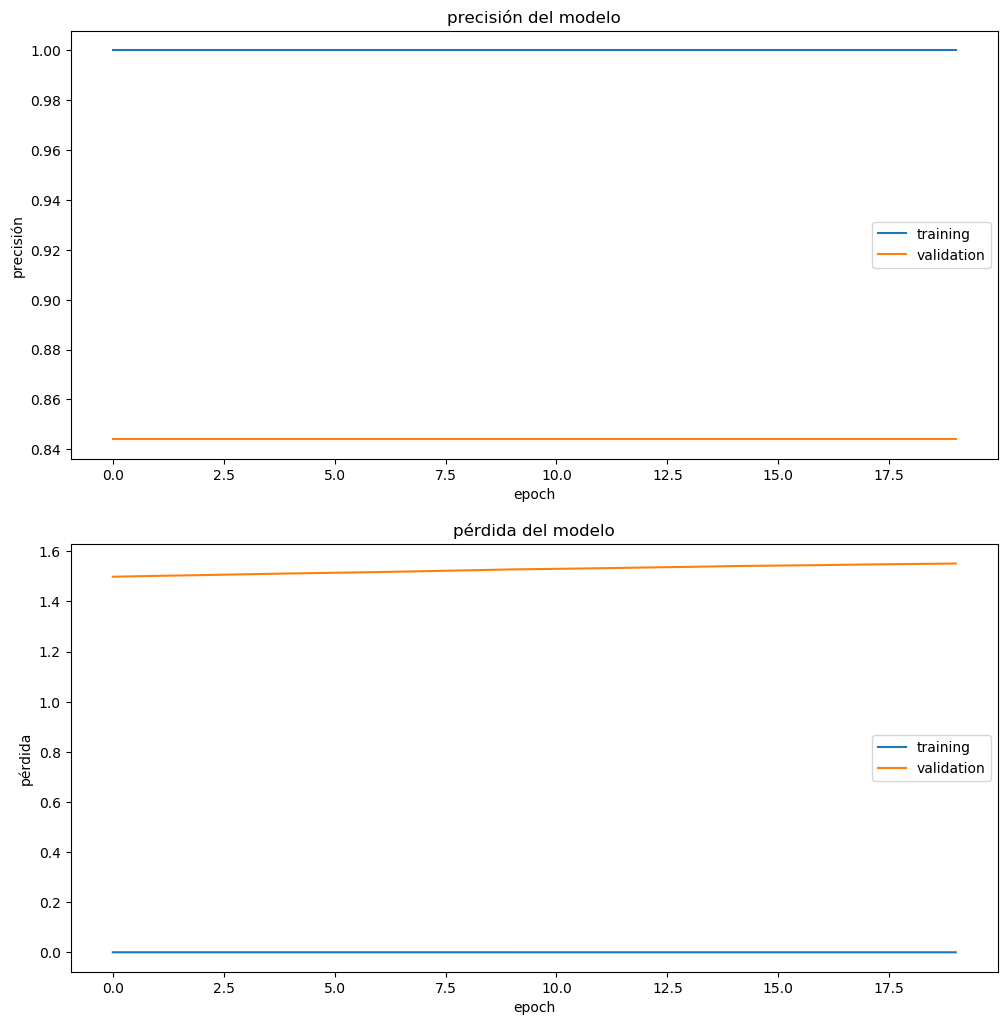

In [313]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'precisión', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'pérdida', 212)



In [306]:
from sklearn.metrics import classification_report, confusion_matrix
#predicciones = modelo.predict(test_x, batch_size=10, verbose=0)
predicciones = modelo.predict(test_x)


In [307]:
matrix = confusion_matrix(test_y.argmax(axis=1), predicciones.argmax(axis=1))
matrix


array([[169,   0],
       [ 17,   0]], dtype=int64)

Nos ha clasificado 13 registros cuyo estado era recurrente como libre de enfermedad.

In [242]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [243]:
cm_plot_labels=['Sin recurrencia','Recurrencia']

Matriz de confusión
[[167   2]
 [ 16   1]]


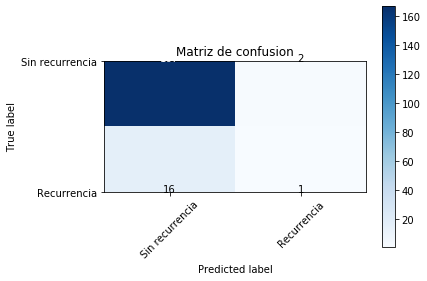

In [244]:
plot_confusion_matrix(cm=matrix,classes=cm_plot_labels,title='Matriz de confusion')